Import Necessary Libraries

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split #split dataset
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve #Import the confusion_matrix function
import matplotlib.pyplot as plt

Generate and Visualize Synthetic Dataset

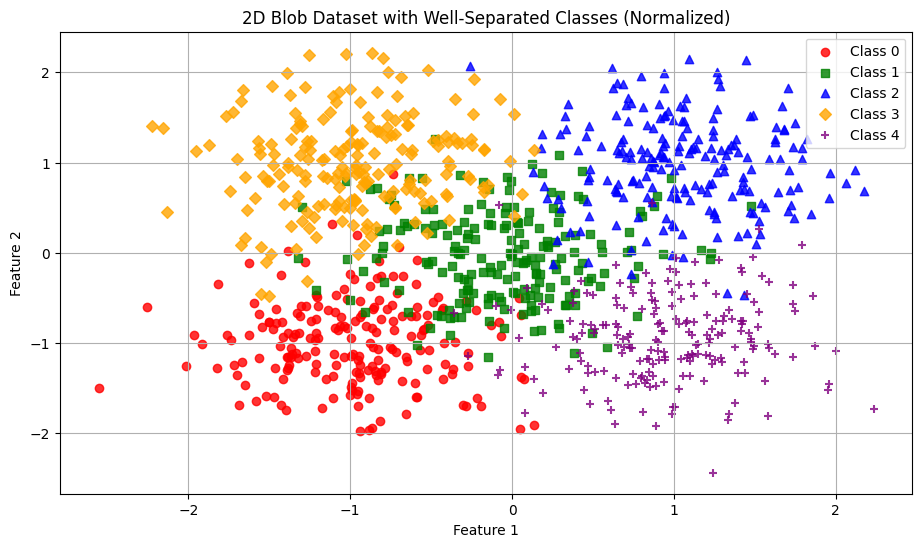

In [ ]:
# Step 1: Generate a synthetic dataset containing input features and corresponding class labels
n_samples = 1000     # Number of data points
n_features = 2       # Number of input features
n_classes = 5        # Number of distinct classes

# Generate the dataset
centers = [[-10, -10], [0, 0], [10, 10], [-10, 10], [10, -10]]
X, Y_labels = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=5, random_state=42)

# Step 2: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Plot the generated and scaled dataset to visualize the distinct classes
plt.figure(figsize=(11, 6))

# Define colors and markers for each class
colors = ['red', 'green', 'blue', 'orange', 'purple']
markers = ['o', 's', '^', 'D', '+']

for class_label in range(n_classes):
    plt.scatter(
        X_scaled[Y_labels == class_label, 0],
        X_scaled[Y_labels == class_label, 1],
        color=colors[class_label],
        marker=markers[class_label],
        label=f'Class {class_label}',
        alpha=0.8
    )

plt.title('2D Blob Dataset with Separated Classes (Normalized)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


Split Dataset into Training and Testing Sets

In [ ]:
#  Y_labels is one-hot encoded
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter name
Y_one_hot = encoder.fit_transform(Y_labels.reshape(-1, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_one_hot, test_size=0.2, random_state=42) #20% testing


Activation Functions and Initialization

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Initialization for ReLU
        self.W1 = np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_sizes[0]))

        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2. / hidden_sizes[0])
        self.b2 = np.zeros((1, hidden_sizes[1]))

        self.W3 = np.random.randn(hidden_sizes[1], hidden_sizes[2]) * np.sqrt(2. / hidden_sizes[1])
        self.b3 = np.zeros((1, hidden_sizes[2]))

        self.WO = np.random.randn(hidden_sizes[2], output_size) * np.sqrt(2. / hidden_sizes[2])
        self.bO = np.zeros((1, output_size))

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, X):
        # Forward pass
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)

        self.ZO = np.dot(self.A3, self.WO) + self.bO
        self.output = self.softmax(self.ZO)
        return self.output

    def back_propagation(self, X, Y, output):
        # Calculate gradients
        error_output = output - Y  # Shape: (batch_size, output_size)
        delta_output = error_output  # For softmax with cross-entropy

        # Gradients for output layer
        dWO = np.dot(self.A3.T, delta_output) / X.shape[0]
        dbO = np.sum(delta_output, axis=0, keepdims=True) / X.shape[0]

        # Backpropagate to third hidden layer
        error_hidden3 = np.dot(delta_output, self.WO.T)
        delta_hidden3 = error_hidden3 * self.relu(self.Z3, der=True)

        dW3 = np.dot(self.A2.T, delta_hidden3) / X.shape[0]
        db3 = np.sum(delta_hidden3, axis=0, keepdims=True) / X.shape[0]

        # Backpropagate to second hidden layer
        error_hidden2 = np.dot(delta_hidden3, self.W3.T)
        delta_hidden2 = error_hidden2 * self.relu(self.Z2, der=True)

        dW2 = np.dot(self.A1.T, delta_hidden2) / X.shape[0]
        db2 = np.sum(delta_hidden2, axis=0, keepdims=True) / X.shape[0]

        # Backpropagate to first hidden layer
        error_hidden1 = np.dot(delta_hidden2, self.W2.T)
        delta_hidden1 = error_hidden1 * self.relu(self.Z1, der=True)

        dW1 = np.dot(X.T, delta_hidden1) / X.shape[0]
        db1 = np.sum(delta_hidden1, axis=0, keepdims=True) / X.shape[0]

        # Update weights and biases
        self.WO -= self.learning_rate * dWO
        self.bO -= self.learning_rate * dbO

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, Y, epochs=10000, print_interval=1000):
        errors = []
        for epoch in range(epochs):
            output = self.feed_forward(X)
            self.back_propagation(X, Y, output)

            # Compute cross-entropy loss
            loss = -np.mean(np.sum(Y * np.log(output + 1e-9), axis=1))
            errors.append(loss)

            if epoch % print_interval == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')
        return errors

    def predict(self, X):
        output = self.feed_forward(X)
        return np.argmax(output, axis=1)


Train the Neural Network

Epoch 0, Loss: 1.8299
Epoch 1000, Loss: 0.6287
Epoch 2000, Loss: 0.4987
Epoch 3000, Loss: 0.4395
Epoch 4000, Loss: 0.4053
Epoch 5000, Loss: 0.3815
Epoch 6000, Loss: 0.3633
Epoch 7000, Loss: 0.3491
Epoch 8000, Loss: 0.3378
Epoch 9000, Loss: 0.3292


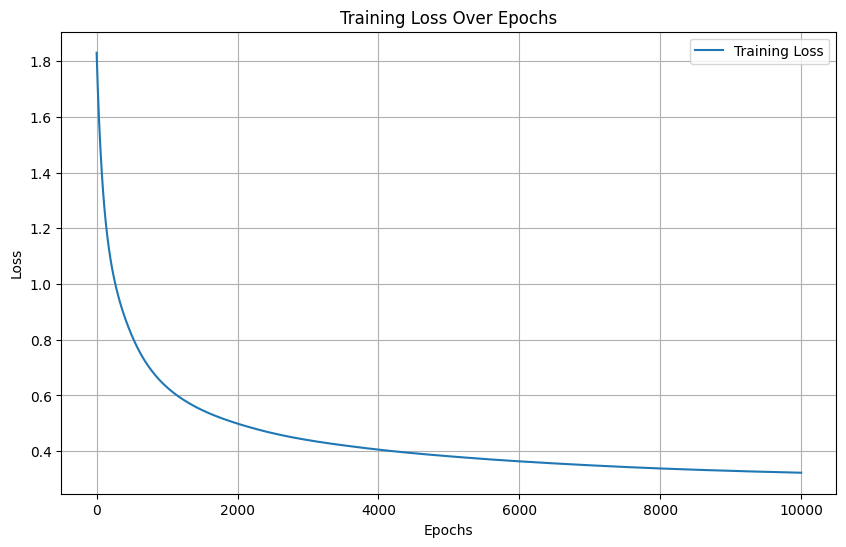

In [ ]:
# Model configuration
input_size = X_train.shape[1]  # Number of features (2)
hidden_sizes = [64, 32, 16]    # Sizes for the three hidden layers
output_size = Y_train.shape[1]  # Number of classes (5)

# Initialize the neural network with updated learning rate
NN = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate=0.001)

# Train the neural network and get the error history
epochs = 10000
errors = NN.train(X_train, Y_train, epochs=epochs, print_interval=1000)

# Plot the error history
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Evaluate the Model

Accuracy: 82.00%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.79      0.86        43
     Class 1       0.65      0.68      0.67        41
     Class 2       0.83      0.86      0.85        35
     Class 3       0.84      0.82      0.83        33
     Class 4       0.85      0.94      0.89        48

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



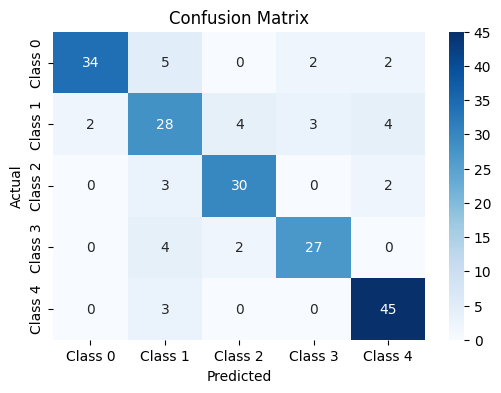

In [ ]:
# Evaluate the network on the test set
predictions = NN.predict(X_test)
true_labels = np.argmax(Y_test, axis=1)

# Calculate and display accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# Generate and display a classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(n_classes)], zero_division=0))

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(n_classes)],
            yticklabels=[f"Class {i}" for i in range(n_classes)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()





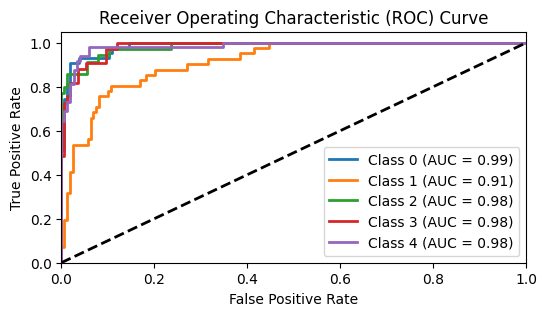

In [ ]:
# Calculate prediction probabilities
pred_probs = NN.feed_forward(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(6, 3))
for i in range(5):
  fpr, tpr, _ = roc_curve(Y_test[:, i], pred_probs[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<h2> **Modifications Made to Implement Multi-Class Classification:-**

 The neural network was designed for a binary classification problem (XOR problem) with a single output neuron and sigmoid activation. To modify this for multi-class classification, here are the key changes are made:

***Output Layer Modification:***

Original Code: The output layer had one neuron with a sigmoid activation function, suitable for binary classification.

Modified Code: The output layer was changed to have n_classes neurons, each corresponding to a different class. The activation function used in the output layer was switched from sigmoid to softmax to handle multi-class probabilities.

***Loss Calculation:***

Original Code: The loss was computed using the difference between the predicted and actual binary outputs.

Modified Code: The loss was computed using cross-entropy for multi-class classification, which measures the difference between the predicted probability distribution and the actual distribution (one-hot encoded labels).

***Backpropagation Adjustments:***

Original Code: The gradients were computed for a single output neuron.

Modified Code: Gradients are now computed for each neuron in the output layer, updating all weights accordingly.

<h2>Conclusion:

***Key Findings:***

 The multi-class classification model was successfully implemented and demonstrated effective performance on the synthetic dataset.

***Challenges & Lessons:***

 Modifying the neural network for multi-class tasks required careful adjustments to the output layer and loss function, deepening understanding of activation functions and backpropagation.

***Future Improvements:***

 Experimenting with different architectures, learning rates, and regularization techniques could further enhance the model's accuracy and generalization abilities.